In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

In [21]:
df = pd.read_csv('/content/drive/MyDrive/lumpy_skin_symptoms_dataset.csv')

In [22]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 749 images belonging to 2 classes.
Found 187 images belonging to 2 classes.


In [23]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_steps=val_generator.samples//val_generator.batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6384 - loss: 0.7384 - val_accuracy: 0.8438 - val_loss: 0.3439
Epoch 2/20
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7188 - loss: 0.4596

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.7188 - loss: 0.4596 - val_accuracy: 0.8500 - val_loss: 0.3698
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 666ms/step - accuracy: 0.7927 - loss: 0.4759 - val_accuracy: 0.8875 - val_loss: 0.3265
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7812 - loss: 0.4528 - val_accuracy: 0.8500 - val_loss: 0.3586
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 607ms/step - accuracy: 0.8254 - loss: 0.4361 - val_accuracy: 0.8625 - val_loss: 0.3343
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7812 - loss: 0.4714 - val_accuracy: 0.8875 - val_loss: 0.3060
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 787ms/step - accuracy: 0.8181 - loss: 0.3674 - val_accuracy: 0.9062 - val_loss: 0.2982
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8438 - loss: 0.3417 - val_accuracy: 0.9000 - val_loss: 0.3044
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 903ms/step - accuracy: 0.8467 - loss: 0.3592 - val_accuracy: 0.9125 - 

In [25]:
val_generator.reset()
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, steps=val_generator.samples//val_generator.batch_size+1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy','Diseased']))

print("F1 Score:", f1_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

Confusion Matrix:
[[96  7]
 [10 74]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.93      0.92       103
    Diseased       0.91      0.88      0.90        84

    accuracy                           0.91       187
   macro avg       0.91      0.91      0.91       187
weighted avg       0.91      0.91      0.91       187

F1 Score: 0.896969696969697
Recall: 0.8809523809523809
Precision: 0.9135802469135802


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step


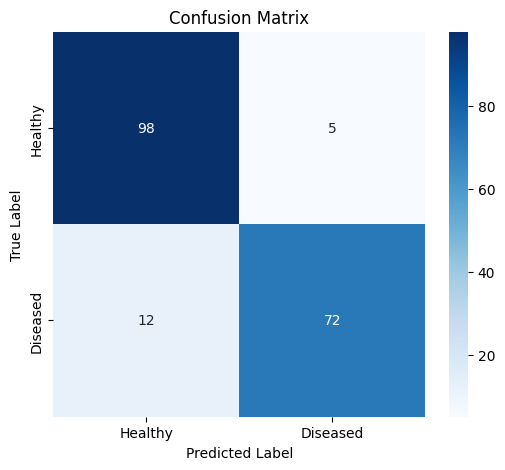

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
classes = ['Healthy', 'Diseased']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
